In [44]:
import os
from PIL import Image, ImageDraw
import torchvision.transforms as transforms
import cv2
import numpy as np
import pandas as pd

In [45]:
import json
data = [json.loads(line) for line in open('/content/fever2-fixers-dev.jsonl', 'r')]

In [53]:
d = data[0]

In [55]:
d.keys()

dict_keys(['id', 'label', 'claim', 'evidence', 'original_id', 'transformation', 'attack', 'annotation'])

In [47]:
claims = []
for x in data:
  claims.append(x["claim"])

In [48]:
labels = []
for x in data:
  labels.append(x["label"])

In [58]:
annotation =[]
for x in data:
  annotation.append(x["annotation"])

In [61]:
attack =[]
for x in data:
  attack.append(x["attack"])

In [64]:
evidence = []
for x in data:
  evidence.append(x["evidence"])

In [67]:
import jieba.posseg as pseg
import os
import keras

In [75]:
def jieba_tokenizer(text):
    words = pseg.cut(text)
    return ' '.join([
        word for word, flag in words if flag != 'x'])

In [76]:
def process(data):
    res = data.apply(jieba_tokenizer)
    return res


def check_merge_idx(data, res):
    assert((data.index == res.index).all(), 'Something error when merge data')

def parallelize(data, func):
    from multiprocessing import cpu_count, Pool
    cores = partitions = cpu_count()
    data_split = np.array_split(data, partitions)
    pool = Pool(cores)
    res = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    check_merge_idx(data, res)
    return res

<ipython-input-76-2085024a8821>:7: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert((data.index == res.index).all(), 'Something error when merge data')


In [102]:
d = {'title1_en': claims, 'title2_en': attack,'lable':labels}
train = pd.DataFrame(data=d)
train.head()

,title1_en,title2_en,lable
0,There is a convicted statutory rapist called C...,there.is.a.called,NOT ENOUGH INFO
1,There exists a producer and an actor called Si...,there.exists.a.called,SUPPORTS
2,Exotic Birds rejected to be an opening band fo...,word replacement,REFUTES
3,The Nice Guys is a 2016 American neo-noir acti...,Multihop,REFUTES
4,Rupert Murdoch's father was not connected to a...,Multihop,REFUTES


In [103]:
print("start to training")
train['title1_tokenized'] = parallelize(train.loc[:, 'title1_en'], process)
train['title2_tokenized'] = parallelize(train.loc[:, 'title2_en'], process)
train.to_csv('tokenized_train.csv',index=True)

start to training


Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model from cache /tmp/jieba.cache
Loading model cost 1.368 seconds.
Prefix dict has been built successfully.
Loading model cost 1.392 seconds.
Prefix dict has been built successfully.
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model from cache /tmp/jieba.cache
Loading model cost 1.398 seconds.
Loading model cost 1.403 seconds.
Prefix dict has been built successfully.
Prefix dict has been built successfully.


In [104]:
train['lable'].value_counts()

REFUTES            396
SUPPORTS           391
NOT ENOUGH INFO    354
Not Enough Info     33
Name: lable, dtype: int64

In [105]:
train.loc[:, ["title2_en", "title2_tokenized"]].head(10)

,title2_en,title2_tokenized
0,there.is.a.called,there . is . a . called
1,there.exists.a.called,there . exists . a . called
2,word replacement,word replacement
3,Multihop,Multihop
4,Multihop,Multihop
5,there.exists.a.that.goes.by.name.of.prn,there . exists . a . that . goes . by . name ....
6,conjunction,conjunction
7,long chain of relations,long chain of relations
8,NotClear,NotClear
9,there.is.not.by.name,there . is . not . by . name


In [106]:
train["lable"].replace({"NOT ENOUGH INFO":"REFUTES"}, inplace=True )
train["lable"].replace({"Not Enough Info":"SUPPORTS"}, inplace=True )

In [108]:
train['lable'].value_counts()

REFUTES     750
SUPPORTS    424
Name: lable, dtype: int64

In [109]:
MAX_NUM_WORDS = 10000
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)

In [110]:
corpus_x1 = train.title1_tokenized
corpus_x2 = train.title2_tokenized
corpus = pd.concat([
    corpus_x1, corpus_x2])
corpus.shape

(2348,)

In [111]:
pd.DataFrame(corpus.iloc[:5],columns=['title'])

,title
0,There is convicted statutory rapist called Chi...
1,There exists producer and an actor called Simo...
2,Exotic Birds rejected to be an opening band fo...
3,The Nice Guys is 2016 American neo noir action...
4,Rupert Murdoch father was not connected to any...


In [112]:
corpus.isna().any()

False

In [113]:
tokenizer.fit_on_texts(corpus)
x1_train = tokenizer.texts_to_sequences(corpus_x1)
x2_train = tokenizer.texts_to_sequences(corpus_x2)

In [114]:
len(x1_train)

1174

In [115]:
x1_train[:1]

[[2, 4, 1466, 1467, 1468, 5, 623, 128]]

In [116]:
for seq in x1_train[:1]:
    print([tokenizer.index_word[idx] for idx in seq])

['there', 'is', 'convicted', 'statutory', 'rapist', 'called', 'chinatown', 'writer']


In [117]:
MAX_SEQUENCE_LENGTH = 20
x1_train = keras.preprocessing.sequence.pad_sequences(x1_train, maxlen=MAX_SEQUENCE_LENGTH)

x2_train = keras.preprocessing.sequence.pad_sequences(x2_train, maxlen=MAX_SEQUENCE_LENGTH)

In [118]:
x1_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    2,    4, 1466, 1467, 1468,    5,  623,  128], dtype=int32)

In [119]:
for seq in x1_train + x2_train:
    assert len(seq) == 20

In [121]:
train.lable[:5]

0     REFUTES
1    SUPPORTS
2     REFUTES
3     REFUTES
4     REFUTES
Name: lable, dtype: object

In [122]:
import numpy as np 

label_to_index = {
    'REFUTES': 0, 
    'SUPPORTS': 1
}

y_train = train.lable.apply(
    lambda x: label_to_index[x])

y_train = np.asarray(y_train) \
            .astype('float32')
y_train0 = y_train
y_train[:30]

array([0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.], dtype=float32)

In [123]:
NUM_CLASSES = 3

MAX_NUM_WORDS = 10000

MAX_SEQUENCE_LENGTH =20

NUM_EMBEDDING_DIM = 256

NUM_LSTM_UNITS = 128

In [124]:
x1_train[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    2,    4, 1466, 1467, 1468,    5,  623,  128],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           2,   10,  114,   14,   16,   73,    5,  220,  240],
       [   0,    0,    0,    0,    0,    0,    0,    0, 1469, 1470, 1471,
          24,  241,   16, 1472,   98,   42,   98,   38,  879],
       [  20,   52,    6,   16, 1473,  329,   82,  114,   14,   73,  102,
          42,  880,    1,  489,  242,   20,  627, 1474, 1475],
       [   0,    0,    0,    0,    0, 1476, 1477,  178,    9,   11, 1478,
          24,  330,  881, 1479,  106,  116,    7, 1480, 1481]],
      dtype=int32)

In [127]:
train.lable[:5]

0     REFUTES
1    SUPPORTS
2     REFUTES
3     REFUTES
4     REFUTES
Name: lable, dtype: object

In [128]:
from keras.utils import np_utils

In [129]:
y_train = keras.utils.np_utils.to_categorical(y_train)

y_train.shape

(1174, 2)

In [130]:
from sklearn.model_selection \
    import train_test_split

VALIDATION_RATIO = 0.1
RANDOM_STATE = 9527

x1_train, x1_val, \
x2_train, x2_val, \
y_train, y_val = \
    train_test_split(
        x1_train, x2_train, y_train, 
        test_size=VALIDATION_RATIO, 
        random_state=RANDOM_STATE
)

In [131]:
print("Training Set")
print("-" * 10)
print(f"x1_train: {x1_train.shape}")
print(f"x2_train: {x2_train.shape}")
print(f"y_train : {y_train.shape}")

print("-" * 10)
print(f"x1_val:   {x1_val.shape}")
print(f"x2_val:   {x2_val.shape}")
print(f"y_val :   {y_val.shape}")
print("-" * 10)
print("Test Set")

Training Set
----------
x1_train: (1056, 20)
x2_train: (1056, 20)
y_train : (1056, 2)
----------
x1_val:   (118, 20)
x2_val:   (118, 20)
y_val :   (118, 2)
----------
Test Set


In [132]:
y_train0 = []
for x in y_train:
  y_train0.append(np.argmax(x))
y_train0 = np.array(y_train0)


In [133]:
y_val0 = []
for x in y_val:
  y_val0.append(np.argmax(x))
y_val0 = np.array(y_val0)



In [134]:
np.max(y_train0)

1

In [135]:
print(x1_train[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0  157
 1973   35  159    7 1974  752]


In [136]:
from sklearn import preprocessing
x1_scaler = preprocessing.StandardScaler().fit(x1_train)
x2_scaler = preprocessing.StandardScaler().fit(x2_train)
X1_scaled = x1_scaler.transform(x1_train)
X2_scaled = x2_scaler.transform(x2_train)
print(X1_scaled[0])

[-0.18081956 -0.19256756 -0.23796343 -0.27087298 -0.28818473 -0.33056904
 -0.3501505  -0.38900679 -0.41356332 -0.46174482 -0.51515569 -0.51543527
 -0.53763132 -0.32377542  1.93126354 -0.52202681 -0.36042709 -0.5208819
  1.69831815 -0.20058378]


In [137]:
from sklearn import preprocessing
x1_scaler = preprocessing.StandardScaler().fit(x1_val)
x2_scaler = preprocessing.StandardScaler().fit(x2_val)
X1_scaled_val = x1_scaler.transform(x1_val)
X2_scaled_val = x2_scaler.transform(x2_val)
print(X2_scaled_val[0])

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.23145502
 -0.26064547 -0.25533935 -0.31223273 -0.40050791 -0.19942559 -0.42902884
 -0.74719959  1.84546807]


In [138]:
print(x2_scaler.scale_)

[  1.           1.           1.           1.           1.
   1.           1.           1.           1.           1.
   1.           0.43937225   2.21093883   3.61765159   3.22988105
   4.06263797  33.23103425  16.25666062  20.22240069 138.11203813]


In [139]:
normalizerx1 = preprocessing.Normalizer().fit(x1_train)
normalizerx2 = preprocessing.Normalizer().fit(x2_train)
normalizedx1 = normalizerx1.transform(x1_train)
normalizedx2 = normalizerx1.transform(x2_train)

In [140]:
print(normalizedx1[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.05415045 0.68050211 0.01207176 0.05484026 0.00241435
 0.68084701 0.25937029]


In [141]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(X1_scaled)

GaussianMixture(n_components=3, n_init=10)

In [142]:
densities = gm.score_samples(X1_scaled)
density_threshold = np.percentile(densities, 3)
anomalies1 = X1_scaled[densities < density_threshold]


In [143]:
anomalies1.shape

(32, 20)

In [144]:
densities = gm.score_samples(X2_scaled)
density_threshold = np.percentile(densities, 3)
anomalies2 = X2_scaled[densities < density_threshold]

In [145]:
anomalies2.shape

(31, 20)

In [146]:
from sklearn.decomposition import PCA

In [147]:
pca = PCA()
pca.fit(X1_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.90) + 1
print(d)

17


In [150]:
import matplotlib.pyplot as plt

def plot_2d_space(X, y, label='Classes'):  
  colors = ['#000000',	'#800000']
  markers = ['8', 'X', '*']
  plt.figure(figsize=(8,8))
  for l, c, m in zip(np.unique(y), colors, markers):
    plt.scatter(
              X[y==l, 0],
              X[y==l, 1],
              c=c, label=l ,marker=m,
              )  
  plt.title(label)
  plt.xlabel('Variation of Data')
  plt.ylabel('Variation of Data')
  plt.legend(fontsize='medium',loc='best')
  plt.show()

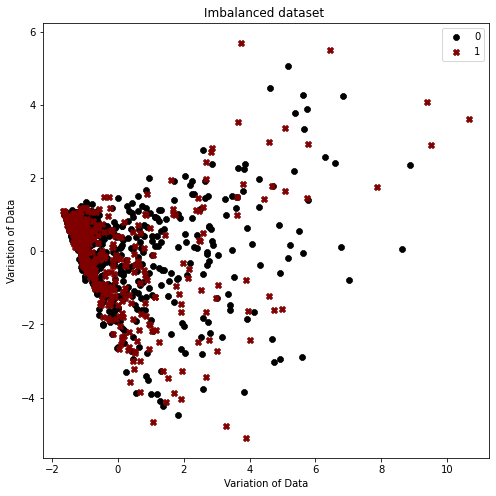

In [151]:
from sklearn.decomposition import PCA

pca = PCA(n_components=18)
X = pca.fit_transform(X1_scaled)
plot_2d_space(X, y_train0, 'Imbalanced dataset ')

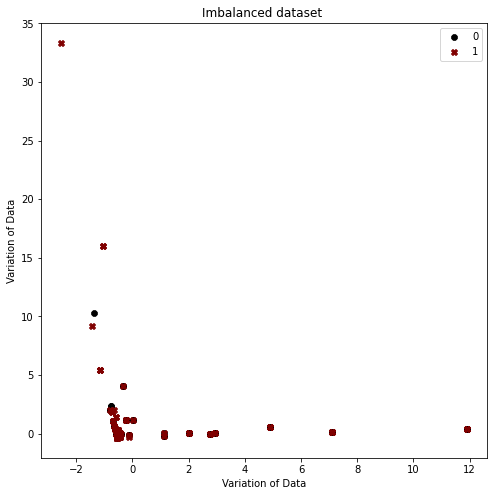

In [152]:
from sklearn.decomposition import PCA

pca = PCA(n_components=18)
X2 = pca.fit_transform(X2_scaled)
plot_2d_space(X2, y_train0, 'Imbalanced dataset ')

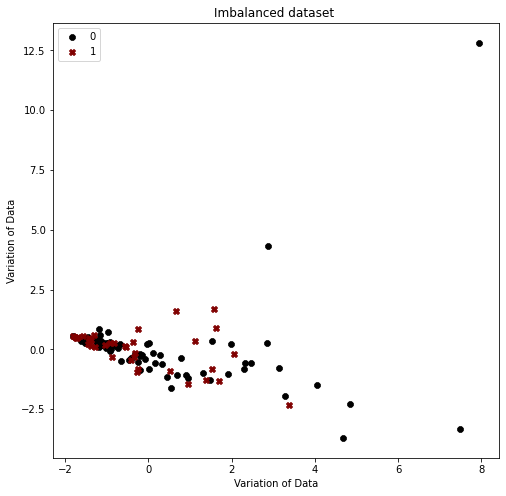

In [153]:
from sklearn.decomposition import PCA

pca = PCA(n_components=18)
X3 = pca.fit_transform(X1_scaled_val)
plot_2d_space(X3, y_val0, 'Imbalanced dataset ')

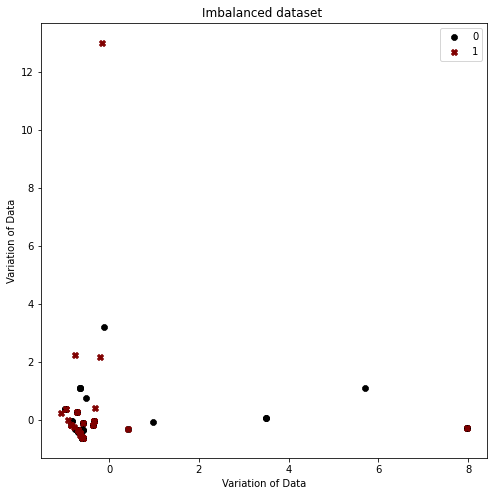

In [154]:
from sklearn.decomposition import PCA

pca = PCA(n_components=18)
X4 = pca.fit_transform(X2_scaled_val)
plot_2d_space(X4, y_val0, 'Imbalanced dataset ')

In [155]:
X_train_totall = np.array([X, X2])
X_valid_totall = np.array([X3, X4])

In [156]:
X_train_totall = X_train_totall.reshape(X_train_totall.shape[1],X_train_totall.shape[0]*X_train_totall.shape[-1])


In [157]:
X_valid_totall = X_valid_totall.reshape(X_valid_totall.shape[1],X_valid_totall.shape[0]*X_valid_totall.shape[-1])

In [158]:
print(X_train_totall.shape)
print(X_valid_totall.shape)

(1056, 36)
(118, 36)


In [159]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [160]:
import time
import numpy as np
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import time
import numpy as np
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

In [161]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier

In [162]:
from sklearn.metrics import accuracy_score

In [163]:
RandomForest=RandomForestClassifier(bootstrap= False,max_depth= 110,max_features= 1,min_samples_leaf= 1,min_samples_split= 5,n_estimators= 50)

In [164]:
RandomForest.fit(X_train_totall, y_train0)
y_pred_trainsm_rnd = RandomForest.predict(X_train_totall)
y_predsm_rnd = RandomForest.predict(X_valid_totall)
accuracy_trainsm = accuracy_score(y_train0, y_pred_trainsm_rnd)
accuracysm = accuracy_score(y_val0, y_predsm_rnd)
print("Accuracysm of random_forest: %.2f%%" % (accuracysm * 100.0))
print("Accuracy trainsm of random_forest: %.2f%%" % (accuracy_trainsm * 100.0))

Accuracysm of random_forest: 65.25%
Accuracy trainsm of random_forest: 93.94%


In [165]:
!pip install scikit-plot

In [166]:
import scikitplot as skplt
import matplotlib.pyplot as plt

In [168]:
probas = RandomForest.predict_proba(X_valid_totall)

In [169]:
y_predsm = RandomForest.predict(X_valid_totall)

In [170]:
y_testsm = y_val0.reshape(y_val0.shape[0])
y_predsm = y_predsm.reshape(y_testsm.shape[0])
print(y_testsm.shape,y_predsm.shape)


(118,) (118,)


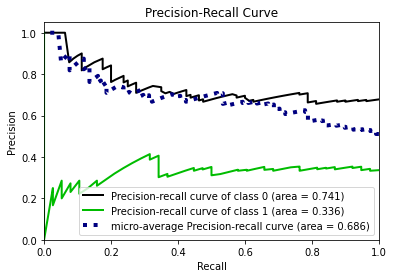

In [171]:
skplt.metrics.plot_precision_recall(y_testsm,probas)

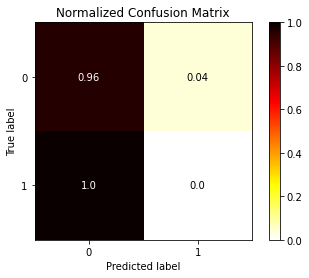

In [172]:
skplt.metrics.plot_confusion_matrix(y_testsm,y_predsm, normalize=True, cmap='hot_r')
plt.show()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


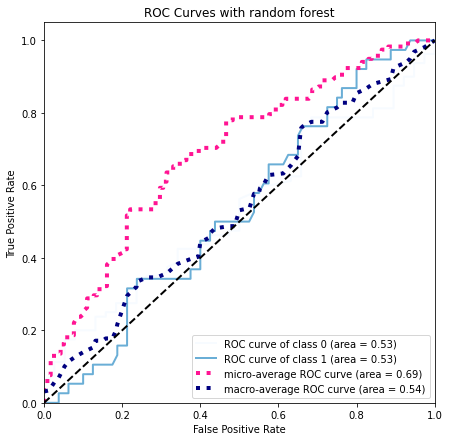

In [173]:
skplt.metrics.plot_roc_curve(y_testsm,probas,title="ROC Curves with random forest", cmap='Blues', figsize=[7,7])
plt.show()

In [174]:
y_score1 =RandomForest.predict_proba(X_valid_totall)
print(y_score1.shape)
print(RandomForest.predict(X_valid_totall).shape)

(118, 2)
(118,)


In [176]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_val0, RandomForest.predict(X_valid_totall), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.67      0.96      0.79        80
     class 1       0.00      0.00      0.00        38

    accuracy                           0.65       118
   macro avg       0.33      0.48      0.39       118
weighted avg       0.45      0.65      0.54       118



In [177]:
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=3)

#Train the model using the training sets
knn.fit(X_train_totall, y_train0)

KNeighborsClassifier(n_neighbors=3)

In [178]:
from sklearn.cluster import MiniBatchKMeans
n_clusters=3 
minibatch_kmeans = MiniBatchKMeans(n_clusters)
minibatch_kmeans.fit(X_train_totall)
from sklearn.metrics import silhouette_score
#print(f'silhouette_score for {n_clusters} of cluster',silhouette_score(X_train_totall, minibatch_kmeans.labels_))


In [179]:
from sklearn import metrics
y_pred_test = knn.predict(X_valid_totall)
#print("Accuracy for train set:",metrics.accuracy_score(y_train0, y_pred))
print("Accuracy for test set:",metrics.accuracy_score(y_val0, y_pred_test))

Accuracy for test set: 0.5847457627118644


In [180]:
probas = knn.predict_proba(X_valid_totall)

In [181]:
y_predsm = knn.predict(X_valid_totall)

In [182]:
y_testsm = y_val0.reshape(y_val0.shape[0])
y_predsm = y_predsm.reshape(y_testsm.shape[0])
print(y_testsm.shape,y_predsm.shape)


(118,) (118,)


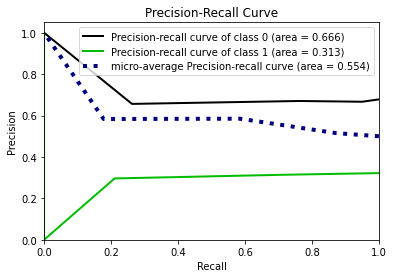

In [183]:
skplt.metrics.plot_precision_recall(y_testsm,probas)

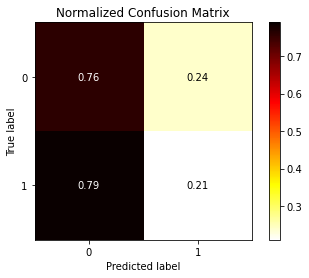

In [184]:
skplt.metrics.plot_confusion_matrix(y_testsm,y_predsm, normalize=True, cmap='hot_r')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


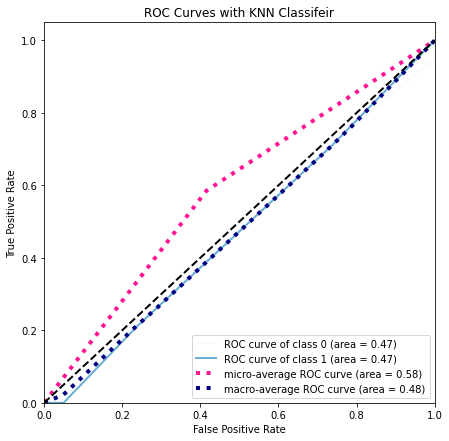

In [185]:
skplt.metrics.plot_roc_curve(y_testsm,probas,title="ROC Curves with KNN Classifeir", cmap='Blues', figsize=[7,7])
plt.show()

In [186]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_val0, y_predsm, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.67      0.76      0.71        80
     class 1       0.30      0.21      0.25        38

    accuracy                           0.58       118
   macro avg       0.48      0.49      0.48       118
weighted avg       0.55      0.58      0.56       118



In [187]:
from imblearn.under_sampling import RandomUnderSampler

OS = RandomUnderSampler(sampling_strategy='auto', random_state=0)
X_rus, y_rus = OS.fit_resample(X_train_totall, y_train0)
print(X_rus.shape, y_rus.shape)

(772, 36) (772,)


In [188]:
from sklearn.ensemble import AdaBoostClassifier

In [189]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_rus, y_rus)

AdaBoostClassifier(n_estimators=100, random_state=0)

In [190]:
y_pred_trainsm_rnd = clf.predict(X_rus)
y_predsm_rnd = clf.predict(X_valid_totall)
accuracy_trainsm = accuracy_score(y_rus, y_pred_trainsm_rnd)
accuracysm = accuracy_score(y_val0, y_predsm_rnd)
print("Accuracysm of random_forest: %.2f%%" % (accuracysm * 100.0))
print("Accuracy trainsm of random_forest: %.2f%%" % (accuracy_trainsm * 100.0))

Accuracysm of random_forest: 48.31%
Accuracy trainsm of random_forest: 78.37%


In [191]:
probas = clf.predict_proba(X_valid_totall)

In [192]:
y_predsm = clf.predict(X_valid_totall)

In [193]:
y_testsm = y_val0.reshape(y_val0.shape[0])
y_predsm = y_predsm.reshape(y_testsm.shape[0])
print(y_testsm.shape,y_predsm.shape)


(118,) (118,)


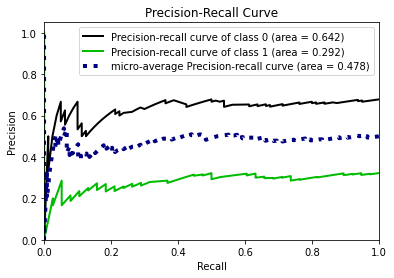

In [194]:
skplt.metrics.plot_precision_recall(y_testsm,probas)

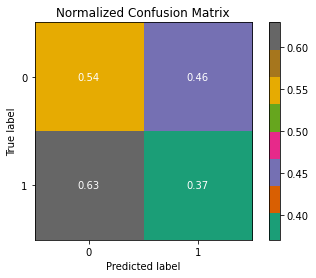

In [201]:
skplt.metrics.plot_confusion_matrix(y_testsm,y_predsm, normalize=True, cmap='Dark2')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


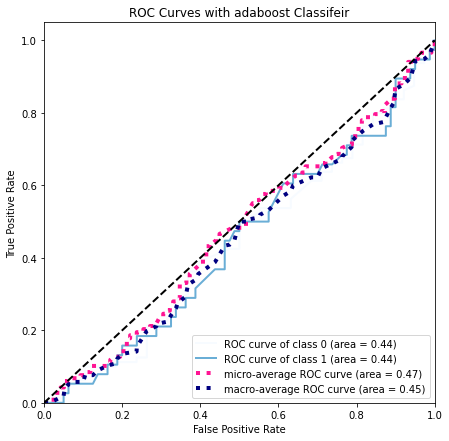

In [202]:
skplt.metrics.plot_roc_curve(y_testsm,probas,title="ROC Curves with adaboost Classifeir", cmap='Blues', figsize=[7,7])
plt.show()

In [203]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_val0, y_predsm, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.64      0.54      0.59        80
     class 1       0.27      0.37      0.31        38

    accuracy                           0.48       118
   macro avg       0.46      0.45      0.45       118
weighted avg       0.52      0.48      0.50       118



In [209]:

from keras import Input
from keras.layers import Embedding,LSTM, concatenate, Dense
from keras.models import Model

top_input = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')
bm_input = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')

embedding_layer = Embedding(
    MAX_NUM_WORDS, NUM_EMBEDDING_DIM)
top_embedded = embedding_layer(
    top_input)
bm_embedded = embedding_layer(
    bm_input)

shared_lstm = LSTM(NUM_LSTM_UNITS)
top_output = shared_lstm(top_embedded)
bm_output = shared_lstm(bm_embedded)

merged = concatenate(
    [top_output, bm_output], 
    axis=-1)

dense =  Dense(
    units=2, 
    activation='softmax')
predictions = dense(merged)

model = Model(
    inputs=[top_input, bm_input], 
    outputs=predictions)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 20, 256)      2560000     ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 128)          197120      ['embedding_1[0][0]',      

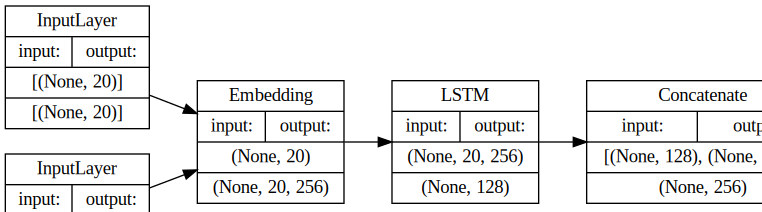

In [210]:
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
plot_model(
    model, 
    to_file='model.png', 
    show_shapes=True, 
    show_layer_names=False, 
    rankdir='LR')

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, rankdir='LR', show_shapes=True, show_layer_names=False,).create(prog='dot', format='svg'))

In [211]:
from tensorflow.keras.optimizers import Adam
lr = 1e-3
opt = Adam(lr=lr, decay=lr)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [213]:
BATCH_SIZE = 64

NUM_EPOCHS = 50

history = model.fit(
    x=[x1_train, x2_train], 
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(
        [x1_val, x2_val], 
        y_val
    ),
    shuffle=True
)

Epoch 1/50
17/17 [==============================] - 5s 303ms/step - loss: 0.6471 - accuracy: 0.6345 - val_loss: 0.6125 - val_accuracy: 0.6949
Epoch 2/50
17/17 [==============================] - 3s 202ms/step - loss: 0.5480 - accuracy: 0.7254 - val_loss: 0.5401 - val_accuracy: 0.7627
Epoch 3/50
17/17 [==============================] - 3s 188ms/step - loss: 0.3541 - accuracy: 0.8598 - val_loss: 0.5721 - val_accuracy: 0.7458
Epoch 4/50
17/17 [==============================] - 3s 167ms/step - loss: 0.1974 - accuracy: 0.9195 - val_loss: 0.6553 - val_accuracy: 0.6864
Epoch 5/50
17/17 [==============================] - 2s 139ms/step - loss: 0.1293 - accuracy: 0.9479 - val_loss: 0.8357 - val_accuracy: 0.7288
Epoch 6/50
17/17 [==============================] - 2s 141ms/step - loss: 0.0988 - accuracy: 0.9650 - val_loss: 0.6962 - val_accuracy: 0.7458
Epoch 7/50
17/17 [==============================] - 2s 138ms/step - loss: 0.0846 - accuracy: 0.9678 - val_loss: 0.8728 - val_accuracy: 0.6949
Epoch 

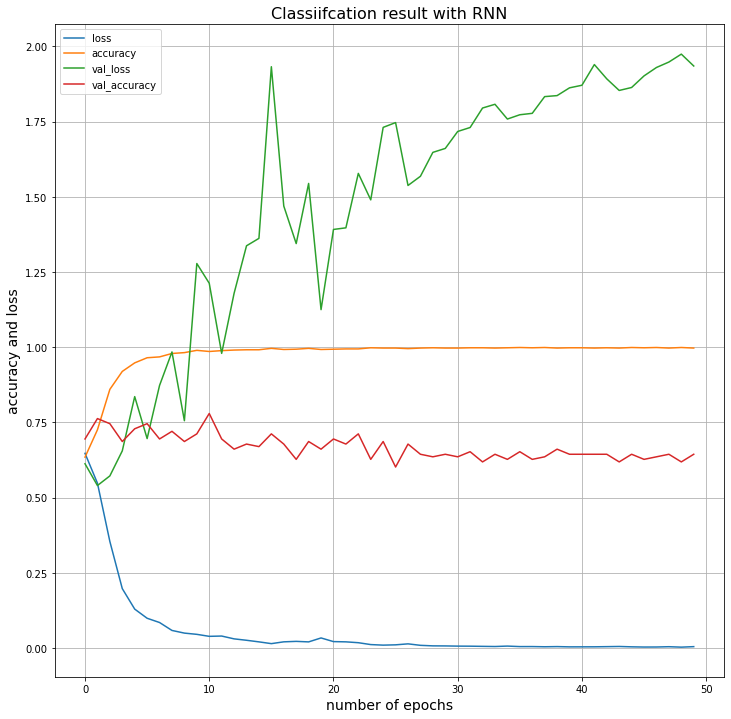

In [214]:
pd.DataFrame(history.history).plot(figsize=(12, 12))
plt.grid(True) # set the vertical range to [0-1]
plt.xlabel('number of epochs', fontsize=14)
plt.ylabel('accuracy and loss', fontsize=14)
plt.title('Classiifcation result with RNN',fontsize=16)
plt.show()

In [215]:
y_val0 = []
for x in y_val:
  y_val0.append(np.argmax(x))
y_val0 = np.array(y_val0)

In [216]:
pred = model.predict([x1_val, x2_val])
pred1 =[]
for x in pred:
  pred1.append(np.argmax(x))
pred1 = np.array(pred1)  

In [217]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_val0,  pred1, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.76      0.70      0.73        80
     class 1       0.45      0.53      0.49        38

    accuracy                           0.64       118
   macro avg       0.61      0.61      0.61       118
weighted avg       0.66      0.64      0.65       118



In [218]:
!pip install scikit-plot

In [219]:
import scikitplot as skplt
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


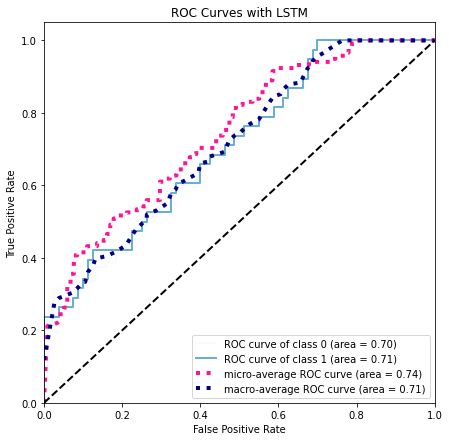

In [220]:
skplt.metrics.plot_roc_curve(y_val0,pred,title="ROC Curves with LSTM", cmap='Blues', figsize=[7,7])
plt.show()

In [221]:

from keras import Input
from keras.layers import Embedding,LSTM, concatenate, Dense, Conv1D, Flatten
from keras.models import Model

top_input = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')
bm_input = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')

embedding_layer = Embedding(
    MAX_NUM_WORDS, NUM_EMBEDDING_DIM)
top_embedded = embedding_layer(
    top_input)
bm_embedded = embedding_layer(
    bm_input)

shared_lstm = Conv1D(kernel_size=3,padding='same',filters=256,activation='relu')
top_output = shared_lstm(top_embedded)
bm_output = shared_lstm(bm_embedded)

merged = concatenate(
    [top_output, bm_output], 
    axis=-1)

dense =  Dense(
    units=2, 
    activation='softmax')
merged = Flatten()(merged)
predictions = dense(merged)

model1 = Model(
    inputs=[top_input, bm_input], 
    outputs=predictions)

model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 20, 256)      2560000     ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 20, 256)      196864      ['embedding_2[0][0]',      

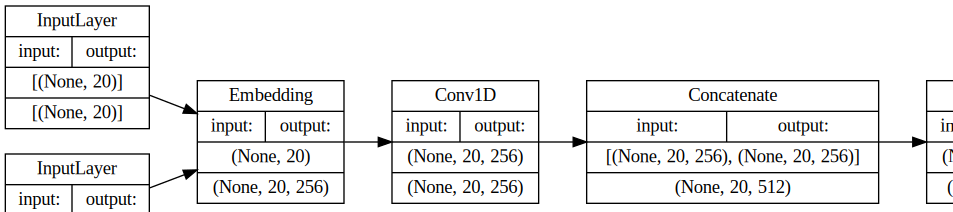

In [222]:
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
plot_model(
    model1, 
    to_file='model.png', 
    show_shapes=True, 
    show_layer_names=False, 
    rankdir='LR')

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model1, rankdir='LR', show_shapes=True, show_layer_names=False,).create(prog='dot', format='svg'))

In [223]:
from tensorflow.keras.optimizers import Adam
lr = 3e-1
opt = Adam(lr=lr, decay=lr)
model1.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [224]:
BATCH_SIZE = 128

NUM_EPOCHS = 50

history = model1.fit(
    x=[x1_train, x2_train], 
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(
        [x1_val, x2_val], 
        y_val
    ),
    shuffle=True
)

Epoch 1/50
9/9 [==============================] - 4s 332ms/step - loss: 966.0244 - accuracy: 0.5360 - val_loss: 30.5337 - val_accuracy: 0.6525
Epoch 2/50
9/9 [==============================] - 3s 337ms/step - loss: 70.4152 - accuracy: 0.6231 - val_loss: 30.8385 - val_accuracy: 0.5424
Epoch 3/50
9/9 [==============================] - 3s 363ms/step - loss: 21.7657 - accuracy: 0.6828 - val_loss: 22.4478 - val_accuracy: 0.5678
Epoch 4/50
9/9 [==============================] - 3s 316ms/step - loss: 9.3517 - accuracy: 0.7405 - val_loss: 17.1888 - val_accuracy: 0.6441
Epoch 5/50
9/9 [==============================] - 3s 331ms/step - loss: 2.0931 - accuracy: 0.7831 - val_loss: 15.7915 - val_accuracy: 0.6695
Epoch 6/50
9/9 [==============================] - 3s 339ms/step - loss: 1.3394 - accuracy: 0.7822 - val_loss: 15.5109 - val_accuracy: 0.6441
Epoch 7/50
9/9 [==============================] - 3s 293ms/step - loss: 1.2559 - accuracy: 0.8314 - val_loss: 15.8964 - val_accuracy: 0.6271
Epoch 8/5

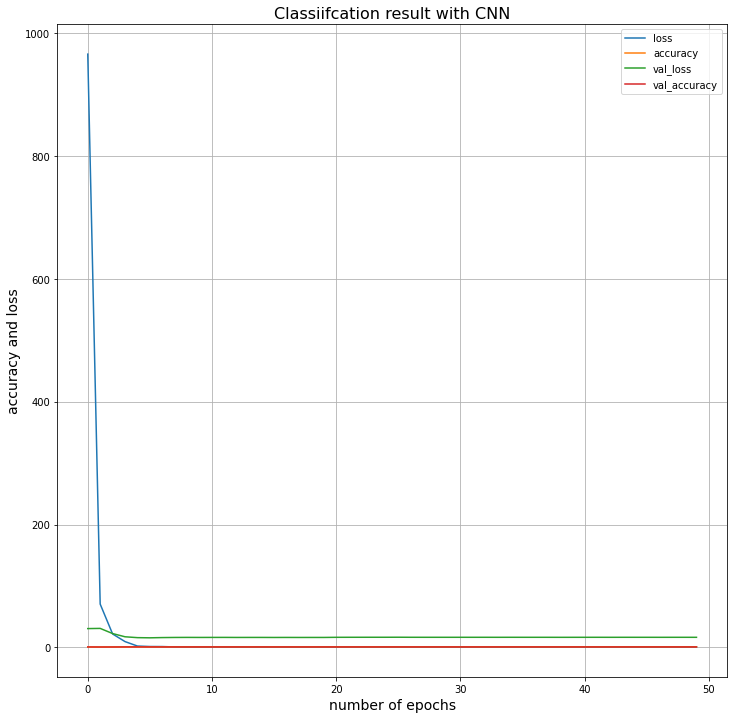

In [225]:
  pd.DataFrame(history.history).plot(figsize=(12, 12))
  plt.grid(True) # set the vertical range to [0-1]
  plt.xlabel('number of epochs', fontsize=14)
  plt.ylabel('accuracy and loss', fontsize=14)
  plt.title('Classiifcation result with CNN',fontsize=16)
  plt.show()

In [226]:
pred = model1.predict([x1_val, x2_val])
pred1 =[]
for x in pred:
  pred1.append(np.argmax(x))
pred1 = np.array(pred1)  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


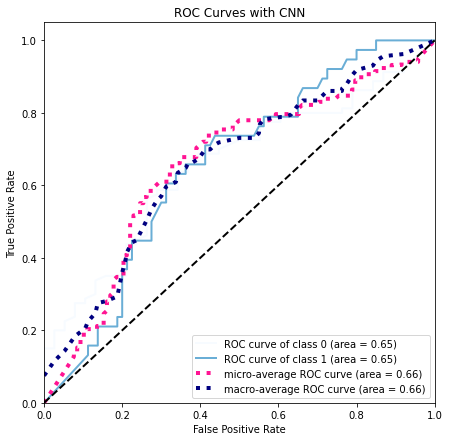

In [227]:
skplt.metrics.plot_roc_curve(y_val0,pred,title="ROC Curves with CNN", cmap='Blues', figsize=[7,7])
plt.show()

In [228]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_val0,  pred1, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.73      0.79      0.76        80
     class 1       0.47      0.39      0.43        38

    accuracy                           0.66       118
   macro avg       0.60      0.59      0.59       118
weighted avg       0.65      0.66      0.65       118

